In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from scipy.stats import genpareto

from preprocess import water_process
# from model.cnn import cnn_4layer, mlp_layer
from model.mlp import mlp_layer

2024-01-13 21:13:26.677562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_process(n_hours, k, masked_value, split_1, split_2)

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(67435, 96, 16) (14451, 96, 16) (14451, 96, 16) (67435, 96) (14451, 96) (14451, 96)


In [6]:
# train_X_mask_rain_acc = np.sum(train_X_mask[:, -24:, 0], axis=1)
# print(train_X_mask_rain_acc.shape)

# test_X_mask_rain_acc = np.sum(test_X_mask[:, -24:, 0], axis=1)
# print(test_X_mask_rain_acc.shape)

train_X_mask_rain_acc = train_X_mask[:, 0, 0]
print(train_X_mask_rain_acc.shape)

val_X_mask_rain_acc = val_X_mask[:, 0, 0]
print(val_X_mask_rain_acc.shape)

test_X_mask_rain_acc = test_X_mask[:, 0, 0]
print(test_X_mask_rain_acc.shape)

(67435,)
(14451,)
(14451,)


In [9]:
percentile = 95

merged_array = np.concatenate((train_X_mask_rain_acc, val_X_mask_rain_acc, test_X_mask_rain_acc))

percentile_rain = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_rain)

95th Percentile of Daily Rain: 0.010711610503493287


In [10]:
# Extract excesses over the threshold from the heavy rainfall data only
excesses = train_X_mask_rain_acc[train_X_mask_rain_acc > percentile_rain] - percentile_rain
excesses.shape

(3251,)

In [11]:
# Fit Generalized Pareto Distribution (GPD) to excesses - returns shape (c), loc, scale for fitted distribution
c, loc, scale = genpareto.fit(excesses)


# Define a function to calculate weights based on the survival function of the GPD
def calculate_weights(rainfall, c, loc, scale, threshold):
    # Weights are the inverse of the survival function
    weights = np.where(rainfall > threshold, 
                       1.0 / (1 - genpareto.cdf(rainfall - threshold, c, loc=loc, scale=scale)),
                       1.0)  # Assign a default weight of 1 for non-extreme events

    # Normalize weights (optional, for stability in training)
    weights /= np.max(weights)
    return weights

# Calculate weights for each sample in your dataset
weights = calculate_weights(train_X_mask_rain_acc, c, loc, scale, percentile_rain)
weights.shape

(67435,)

(array([6.6055e+04, 6.2400e+02, 3.0400e+02, 1.8100e+02, 9.6000e+01,
        5.5000e+01, 4.5000e+01, 2.9000e+01, 1.5000e+01, 8.0000e+00,
        7.0000e+00, 3.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.03356971, 0.08189122, 0.13021274, 0.17853425, 0.22685577,
        0.27517728, 0.3234988 , 0.37182031, 0.42014183, 0.46846334,
        0.51678485, 0.56510637, 0.61342788, 0.6617494 , 0.71007091,
        0.75839243, 0.80671394, 0.85503546, 0.90335697, 0.95167849,
        1.        ]),
 <BarContainer object of 20 artists>)

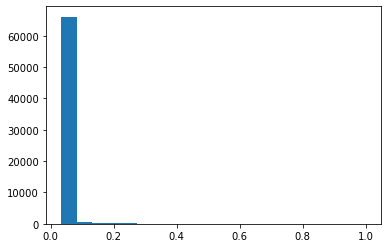

In [12]:
plt.hist(weights, bins=20)

In [13]:
np.save('ws_sample_weights_EVT.npy', weights)

### train_X_mask_filter

In [29]:
train_X_mask_extreme = train_X_mask[train_X_mask_rain_acc > percentile_rain]
print(train_X_mask_extreme.shape)

train_ws_y_extreme = train_ws_y[train_X_mask_rain_acc > percentile_rain]
print(train_ws_y_extreme.shape)

(3355, 96, 16)
(3355, 96)


In [30]:
train_X_mask_normal = train_X_mask[train_X_mask_rain_acc <= percentile_rain]
print(train_X_mask_normal.shape)

train_ws_y_normal = train_ws_y[train_X_mask_rain_acc <= percentile_rain]
print(train_ws_y_normal.shape)

(64080, 96, 16)
(64080, 96)


### val_X_mask_filter

In [31]:
val_X_mask_extreme = val_X_mask[val_X_mask_rain_acc > percentile_rain]
print(val_X_mask_extreme.shape)

val_ws_y_extreme = val_ws_y[val_X_mask_rain_acc > percentile_rain]
print(val_ws_y_extreme.shape)

(555, 96, 16)
(555, 96)


In [32]:
val_X_mask_normal = val_X_mask[val_X_mask_rain_acc <= percentile_rain]
print(val_X_mask_normal.shape)

val_ws_y_normal = val_ws_y[val_X_mask_rain_acc <= percentile_rain]
print(val_ws_y_normal.shape)

(13896, 96, 16)
(13896, 96)


### test_X_mask_filter

In [33]:
test_X_mask_extreme = test_X_mask[test_X_mask_rain_acc > percentile_rain]
print(test_X_mask_extreme.shape)

test_ws_y_extreme = test_ws_y[test_X_mask_rain_acc > percentile_rain]
print(test_ws_y_extreme.shape)

(1060, 96, 16)
(1060, 96)


In [34]:
test_X_mask_normal = test_X_mask[test_X_mask_rain_acc <= percentile_rain]
print(test_X_mask_normal.shape)

test_ws_y_normal = test_ws_y[test_X_mask_rain_acc <= percentile_rain]
print(test_ws_y_normal.shape)

(13391, 96, 16)
(13391, 96)


### Model

In [35]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0  # 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k*4
input_shape = train_X_mask.shape[1:]

In [36]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [37]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/water_weighted_EVT_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=weights
         )

Epoch 1/1000
132/132 - 4s - loss: 6.5197e-04 - mae: 0.0735 - val_loss: 0.0038 - val_mae: 0.0488

Epoch 00001: val_mae improved from inf to 0.04877, saving model to ../../saved_models/water_weighted_EVT.h5
Epoch 2/1000
132/132 - 2s - loss: 5.1046e-05 - mae: 0.0229 - val_loss: 0.0021 - val_mae: 0.0368

Epoch 00002: val_mae improved from 0.04877 to 0.03675, saving model to ../../saved_models/water_weighted_EVT.h5
Epoch 3/1000
132/132 - 2s - loss: 2.2022e-05 - mae: 0.0134 - val_loss: 0.0015 - val_mae: 0.0311

Epoch 00003: val_mae improved from 0.03675 to 0.03110, saving model to ../../saved_models/water_weighted_EVT.h5
Epoch 4/1000
132/132 - 2s - loss: 1.7503e-05 - mae: 0.0113 - val_loss: 0.0014 - val_mae: 0.0306

Epoch 00004: val_mae improved from 0.03110 to 0.03058, saving model to ../../saved_models/water_weighted_EVT.h5
Epoch 5/1000
132/132 - 2s - loss: 1.6149e-05 - mae: 0.0109 - val_loss: 0.0013 - val_mae: 0.0290

Epoch 00005: val_mae improved from 0.03058 to 0.02905, saving model to 


Epoch 00050: val_mae did not improve from 0.02457
Epoch 51/1000
132/132 - 2s - loss: 5.8335e-06 - mae: 0.0066 - val_loss: 0.0013 - val_mae: 0.0282

Epoch 00051: val_mae did not improve from 0.02457
Epoch 52/1000
132/132 - 2s - loss: 6.0528e-06 - mae: 0.0068 - val_loss: 0.0012 - val_mae: 0.0269

Epoch 00052: val_mae did not improve from 0.02457
Epoch 53/1000
132/132 - 2s - loss: 5.8894e-06 - mae: 0.0067 - val_loss: 0.0011 - val_mae: 0.0257

Epoch 00053: val_mae did not improve from 0.02457
Epoch 54/1000
132/132 - 2s - loss: 6.1023e-06 - mae: 0.0069 - val_loss: 9.6721e-04 - val_mae: 0.0244

Epoch 00054: val_mae improved from 0.02457 to 0.02436, saving model to ../../saved_models/water_weighted_EVT.h5
Epoch 55/1000
132/132 - 2s - loss: 6.0086e-06 - mae: 0.0068 - val_loss: 0.0011 - val_mae: 0.0256

Epoch 00055: val_mae did not improve from 0.02436
Epoch 56/1000
132/132 - 2s - loss: 5.7393e-06 - mae: 0.0065 - val_loss: 8.5066e-04 - val_mae: 0.0230

Epoch 00056: val_mae improved from 0.0243

132/132 - 2s - loss: 4.6739e-06 - mae: 0.0058 - val_loss: 7.6301e-04 - val_mae: 0.0210

Epoch 00102: val_mae did not improve from 0.01946
Epoch 103/1000
132/132 - 2s - loss: 4.6687e-06 - mae: 0.0059 - val_loss: 8.9975e-04 - val_mae: 0.0226

Epoch 00103: val_mae did not improve from 0.01946
Epoch 104/1000
132/132 - 2s - loss: 4.4825e-06 - mae: 0.0057 - val_loss: 7.7199e-04 - val_mae: 0.0207

Epoch 00104: val_mae did not improve from 0.01946
Epoch 105/1000
132/132 - 2s - loss: 4.7982e-06 - mae: 0.0060 - val_loss: 8.2363e-04 - val_mae: 0.0221

Epoch 00105: val_mae did not improve from 0.01946
Epoch 106/1000
132/132 - 2s - loss: 4.6051e-06 - mae: 0.0058 - val_loss: 8.6675e-04 - val_mae: 0.0225

Epoch 00106: val_mae did not improve from 0.01946
Epoch 107/1000
132/132 - 2s - loss: 4.6592e-06 - mae: 0.0059 - val_loss: 7.2272e-04 - val_mae: 0.0202

Epoch 00107: val_mae did not improve from 0.01946
Epoch 108/1000
132/132 - 2s - loss: 4.4256e-06 - mae: 0.0056 - val_loss: 7.8430e-04 - val_mae: 0.


Epoch 00155: val_mae did not improve from 0.01939
Epoch 156/1000
132/132 - 2s - loss: 4.0180e-06 - mae: 0.0054 - val_loss: 8.3645e-04 - val_mae: 0.0212

Epoch 00156: val_mae did not improve from 0.01939
Epoch 157/1000
132/132 - 2s - loss: 4.1016e-06 - mae: 0.0055 - val_loss: 7.8876e-04 - val_mae: 0.0205

Epoch 00157: val_mae did not improve from 0.01939
Epoch 158/1000
132/132 - 2s - loss: 3.9416e-06 - mae: 0.0053 - val_loss: 8.1156e-04 - val_mae: 0.0204

Epoch 00158: val_mae did not improve from 0.01939
Epoch 159/1000
132/132 - 2s - loss: 4.0754e-06 - mae: 0.0055 - val_loss: 0.0010 - val_mae: 0.0240

Epoch 00159: val_mae did not improve from 0.01939
Epoch 160/1000
132/132 - 2s - loss: 4.1210e-06 - mae: 0.0055 - val_loss: 8.3953e-04 - val_mae: 0.0212

Epoch 00160: val_mae did not improve from 0.01939
Epoch 161/1000
132/132 - 2s - loss: 3.9221e-06 - mae: 0.0053 - val_loss: 9.0572e-04 - val_mae: 0.0221

Epoch 00161: val_mae did not improve from 0.01939
Epoch 162/1000
132/132 - 2s - loss:

132/132 - 2s - loss: 3.6120e-06 - mae: 0.0051 - val_loss: 8.3913e-04 - val_mae: 0.0213

Epoch 00209: val_mae did not improve from 0.01902
Epoch 210/1000
132/132 - 2s - loss: 3.6245e-06 - mae: 0.0051 - val_loss: 7.8421e-04 - val_mae: 0.0201

Epoch 00210: val_mae did not improve from 0.01902
Epoch 211/1000
132/132 - 2s - loss: 3.6575e-06 - mae: 0.0051 - val_loss: 9.5809e-04 - val_mae: 0.0231

Epoch 00211: val_mae did not improve from 0.01902
Epoch 212/1000
132/132 - 2s - loss: 3.7254e-06 - mae: 0.0052 - val_loss: 0.0011 - val_mae: 0.0252

Epoch 00212: val_mae did not improve from 0.01902
Epoch 213/1000
132/132 - 2s - loss: 3.6145e-06 - mae: 0.0051 - val_loss: 7.5229e-04 - val_mae: 0.0199

Epoch 00213: val_mae did not improve from 0.01902
Epoch 214/1000
132/132 - 2s - loss: 3.8318e-06 - mae: 0.0054 - val_loss: 7.9271e-04 - val_mae: 0.0205

Epoch 00214: val_mae did not improve from 0.01902
Epoch 215/1000
132/132 - 2s - loss: 3.4825e-06 - mae: 0.0050 - val_loss: 8.2475e-04 - val_mae: 0.0212


Epoch 00262: val_mae did not improve from 0.01785
Epoch 263/1000
132/132 - 2s - loss: 3.5444e-06 - mae: 0.0051 - val_loss: 8.6275e-04 - val_mae: 0.0216

Epoch 00263: val_mae did not improve from 0.01785
Epoch 264/1000
132/132 - 2s - loss: 3.3848e-06 - mae: 0.0050 - val_loss: 8.7551e-04 - val_mae: 0.0216

Epoch 00264: val_mae did not improve from 0.01785
Epoch 265/1000
132/132 - 2s - loss: 3.4087e-06 - mae: 0.0050 - val_loss: 8.2826e-04 - val_mae: 0.0209

Epoch 00265: val_mae did not improve from 0.01785
Epoch 266/1000
132/132 - 2s - loss: 3.3266e-06 - mae: 0.0049 - val_loss: 6.5962e-04 - val_mae: 0.0185

Epoch 00266: val_mae did not improve from 0.01785
Epoch 267/1000
132/132 - 2s - loss: 3.4209e-06 - mae: 0.0050 - val_loss: 8.5084e-04 - val_mae: 0.0215

Epoch 00267: val_mae did not improve from 0.01785
Epoch 268/1000
132/132 - 2s - loss: 3.4040e-06 - mae: 0.0050 - val_loss: 8.3003e-04 - val_mae: 0.0210

Epoch 00268: val_mae did not improve from 0.01785
Epoch 269/1000
132/132 - 2s - l


Epoch 00316: val_mae did not improve from 0.01785
Epoch 317/1000
132/132 - 2s - loss: 3.1551e-06 - mae: 0.0047 - val_loss: 7.5542e-04 - val_mae: 0.0198

Epoch 00317: val_mae did not improve from 0.01785
Epoch 318/1000
132/132 - 2s - loss: 3.2380e-06 - mae: 0.0048 - val_loss: 8.6666e-04 - val_mae: 0.0214

Epoch 00318: val_mae did not improve from 0.01785
Epoch 319/1000
132/132 - 2s - loss: 3.2678e-06 - mae: 0.0049 - val_loss: 7.6087e-04 - val_mae: 0.0199

Epoch 00319: val_mae did not improve from 0.01785
Epoch 320/1000
132/132 - 2s - loss: 3.1242e-06 - mae: 0.0047 - val_loss: 6.6933e-04 - val_mae: 0.0186

Epoch 00320: val_mae did not improve from 0.01785
Epoch 321/1000
132/132 - 2s - loss: 3.1836e-06 - mae: 0.0048 - val_loss: 7.3519e-04 - val_mae: 0.0196

Epoch 00321: val_mae did not improve from 0.01785
Epoch 322/1000
132/132 - 2s - loss: 3.2272e-06 - mae: 0.0048 - val_loss: 7.4245e-04 - val_mae: 0.0195

Epoch 00322: val_mae did not improve from 0.01785
Epoch 323/1000
132/132 - 2s - l

132/132 - 2s - loss: 3.0504e-06 - mae: 0.0047 - val_loss: 8.8757e-04 - val_mae: 0.0217

Epoch 00370: val_mae did not improve from 0.01759
Epoch 371/1000
132/132 - 2s - loss: 3.1077e-06 - mae: 0.0048 - val_loss: 7.4983e-04 - val_mae: 0.0197

Epoch 00371: val_mae did not improve from 0.01759
Epoch 372/1000
132/132 - 2s - loss: 3.0558e-06 - mae: 0.0047 - val_loss: 8.3947e-04 - val_mae: 0.0211

Epoch 00372: val_mae did not improve from 0.01759
Epoch 373/1000
132/132 - 2s - loss: 3.0528e-06 - mae: 0.0047 - val_loss: 8.4851e-04 - val_mae: 0.0216

Epoch 00373: val_mae did not improve from 0.01759
Epoch 374/1000
132/132 - 2s - loss: 3.1304e-06 - mae: 0.0048 - val_loss: 7.6951e-04 - val_mae: 0.0199

Epoch 00374: val_mae did not improve from 0.01759
Epoch 375/1000
132/132 - 2s - loss: 3.1150e-06 - mae: 0.0048 - val_loss: 7.4578e-04 - val_mae: 0.0196

Epoch 00375: val_mae did not improve from 0.01759
Epoch 376/1000
132/132 - 2s - loss: 3.0932e-06 - mae: 0.0047 - val_loss: 8.2720e-04 - val_mae: 0.

132/132 - 2s - loss: 3.0716e-06 - mae: 0.0048 - val_loss: 6.7904e-04 - val_mae: 0.0187

Epoch 00424: val_mae did not improve from 0.01759
Epoch 425/1000
132/132 - 2s - loss: 2.9914e-06 - mae: 0.0047 - val_loss: 7.5265e-04 - val_mae: 0.0193

Epoch 00425: val_mae did not improve from 0.01759
Epoch 426/1000
132/132 - 2s - loss: 3.0149e-06 - mae: 0.0047 - val_loss: 7.8841e-04 - val_mae: 0.0202

Epoch 00426: val_mae did not improve from 0.01759
Epoch 427/1000
132/132 - 2s - loss: 2.9510e-06 - mae: 0.0046 - val_loss: 7.6787e-04 - val_mae: 0.0199

Epoch 00427: val_mae did not improve from 0.01759
Epoch 428/1000
132/132 - 2s - loss: 2.9270e-06 - mae: 0.0046 - val_loss: 8.1290e-04 - val_mae: 0.0208

Epoch 00428: val_mae did not improve from 0.01759
Epoch 429/1000
132/132 - 2s - loss: 2.9773e-06 - mae: 0.0046 - val_loss: 8.6423e-04 - val_mae: 0.0215

Epoch 00429: val_mae did not improve from 0.01759
Epoch 430/1000
132/132 - 2s - loss: 2.9084e-06 - mae: 0.0046 - val_loss: 7.2189e-04 - val_mae: 0.

132/132 - 2s - loss: 2.7867e-06 - mae: 0.0044 - val_loss: 7.9865e-04 - val_mae: 0.0207

Epoch 00478: val_mae did not improve from 0.01759
Epoch 479/1000
132/132 - 2s - loss: 3.0238e-06 - mae: 0.0048 - val_loss: 7.9876e-04 - val_mae: 0.0200

Epoch 00479: val_mae did not improve from 0.01759
Epoch 480/1000
132/132 - 2s - loss: 2.8376e-06 - mae: 0.0045 - val_loss: 7.7083e-04 - val_mae: 0.0195

Epoch 00480: val_mae did not improve from 0.01759
Epoch 481/1000
132/132 - 2s - loss: 2.8330e-06 - mae: 0.0045 - val_loss: 8.0312e-04 - val_mae: 0.0203

Epoch 00481: val_mae did not improve from 0.01759
Epoch 482/1000
132/132 - 2s - loss: 2.8177e-06 - mae: 0.0045 - val_loss: 7.5548e-04 - val_mae: 0.0195

Epoch 00482: val_mae did not improve from 0.01759
Epoch 483/1000
132/132 - 2s - loss: 2.9640e-06 - mae: 0.0047 - val_loss: 7.1134e-04 - val_mae: 0.0187

Epoch 00483: val_mae did not improve from 0.01759
Epoch 484/1000
132/132 - 2s - loss: 2.7884e-06 - mae: 0.0045 - val_loss: 7.1120e-04 - val_mae: 0.


Epoch 00531: val_mae did not improve from 0.01759
Epoch 532/1000
132/132 - 2s - loss: 2.7051e-06 - mae: 0.0044 - val_loss: 8.4807e-04 - val_mae: 0.0201

Epoch 00532: val_mae did not improve from 0.01759
Epoch 533/1000
132/132 - 2s - loss: 2.8014e-06 - mae: 0.0045 - val_loss: 8.8979e-04 - val_mae: 0.0208

Epoch 00533: val_mae did not improve from 0.01759
Epoch 534/1000
132/132 - 2s - loss: 2.7737e-06 - mae: 0.0045 - val_loss: 8.7002e-04 - val_mae: 0.0207

Epoch 00534: val_mae did not improve from 0.01759
Epoch 535/1000
132/132 - 2s - loss: 2.8310e-06 - mae: 0.0045 - val_loss: 7.8568e-04 - val_mae: 0.0195

Epoch 00535: val_mae did not improve from 0.01759
Epoch 536/1000
132/132 - 2s - loss: 2.7468e-06 - mae: 0.0045 - val_loss: 9.1633e-04 - val_mae: 0.0211

Epoch 00536: val_mae did not improve from 0.01759
Epoch 537/1000
132/132 - 2s - loss: 2.8491e-06 - mae: 0.0046 - val_loss: 8.3681e-04 - val_mae: 0.0200

Epoch 00537: val_mae did not improve from 0.01759
Epoch 538/1000
132/132 - 2s - l